# Adaptive Query Routing Chatbot

In this notebook, we show how ML developers and AI engineers can implement a simple chatbot using routing multiple LLMs. We first need to understand the limitation of the current chatbot system, by understanding the paper, When and How to Augment Your Input: Question Routing Helps Balance the Accuracy and Efficiency of Large Language Models (NAACL 2025 Findings)

Recent Large Language Models (LLM) show remarkable achievements in Natural Language Processing. However, the direct application of LLM to real-world scenarios might be limited due to its hallucination problem. To mitigate this, query expansion with additional information related to the question can be exploited. Indeed, query expansion approaches, such as Retrieved Augmented Generation, are among the most popular methods to improve the quality of LLM's response. In this paper, the author insists that every question might not require query expansion, showing that the query expansion approach has about ten times longer latency than generating direct answers but gets only a moderate increase in accuracy.

The authors show adaptive routing could balance accuracy and efficiency in answering each question. The figure from the [paper](https://aclanthology.org/2025.findings-naacl.200.pdf) described below shows a brief view of the query routing approach. 

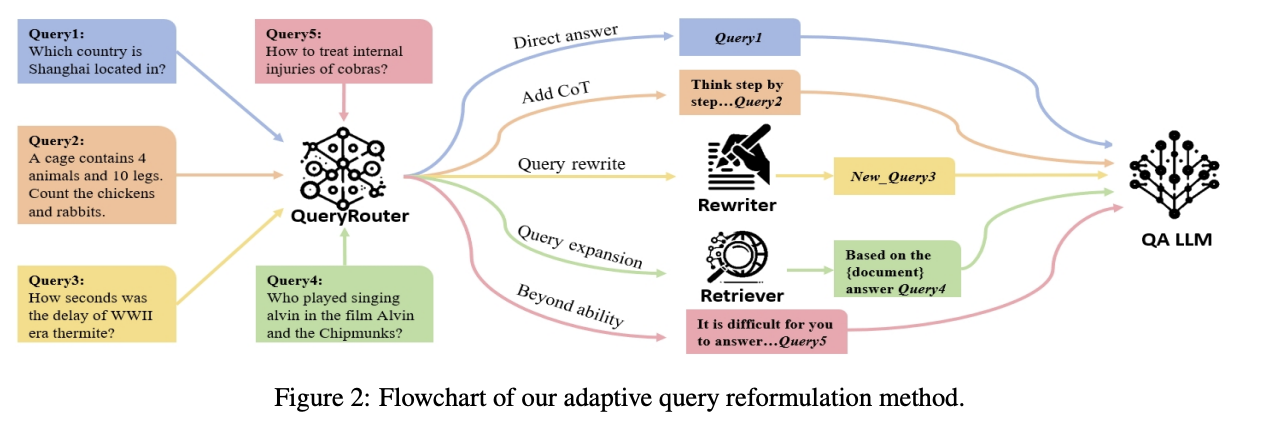

In this notebook, we'll explore how an adaptive query routing strategy can be used to build a simple chatbot system. The overall workflow is as follows:

When a user submits a question, the QueryRouter determines whether the query requires augmentation or if it should be handled by a more capable model.

The chatbot system typically integrates two or three different LLMs, each serving a specific purpose:

A model dedicated to query routing (called QueryRouter).
A lightweight model for handling straightforward questions, optimized for speed and efficiency.
A more powerful model for complex questions, focusing on accuracy and reasoning.
The QueryRouter evaluates each input and selects the most appropriate response strategy:

Provide a direct answer.
Enhance the question with promoting Chain-of-Thought reasoning.
Rewrite the query for clarity, then generate a direct answer.
If the question is too challenging, escalate it to a stronger model for a response.
Once the appropriate routing decision is made, the corresponding adaptive prompt is applied to the question. The final response is generated based on this tailored input.

Let's dive into how this prototype operates.


## Prerequisites
- Access to a RNGD servers
- FuriosaSDK 2025.3.0
- Install dependencies
- Choose an AI application framework (we'll use Langchain)

In [3]:
!pip install langchain_openai langchain 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.8/767.8 kB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [langchain]19 [langchain]core]


In [4]:
from langchain_openai import ChatOpenAI
from langchain.chains.router import MultiRouteChain
from langchain.chains.router.llm_router import LLMRouterChain, RouterOutputParser
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# Connecting to multiple LLMs using OpenAI Compatible Server

First, load multiple LLMs to support the routing functionality of the chatbot system. Create two LangChain ChatOpenAI instances, each configured to use a different local LLM API endpoint. These instances will allow LangChain to route incoming questions to the appropriate model based on their complexity.

The Llama 3.1 8B model can be used for both the QueryRouter and for answering simpler questions. For more challenging queries- those that the QueryRouter determines are beyond its scope- a more capable model, DeepSeek-R1-Distill-Llama-8B will be used to generate the final response.


#### Launch server 1
```
furiosa-llm serve furiosa-ai/Llama-3.1-8B-Instruct --port 8000
```

#### Launch server 2
```
furiosa-llm serve furiosa-ai/DeepSeek-R1-Distill-Llama-8B --port 8888
````

In [5]:
llm_easy = ChatOpenAI(
    base_url="http://localhost:8000/v1",  # llama-8b
    api_key="token-abc123",
    model="furiosa-ai/Llama-3.1-8B-Instruct"
)

llm_hard = ChatOpenAI(
    base_url="http://localhost:8888/v1",  # deepseek-8b
    api_key="token-abc456",
    model="furiosa-ai/DeepSeek-R1-Distill-Llama-8B"
)

# Set up routing mechanism in a LangChain
We set up a routing approach in a LangChain chatbot using a custom prompt to decide how to handle user input. Based on the input question, it selects a strategy (e.g., direct answer, chain of thought, etc.) and routes the question accordingly.

There are the four possible strategies the router can select from:

direct answer: The question is easy and can be answered directly.
add CoT (Chain of Thought): The question is complex and should be answered step by step.
query rewrite: The question is unclear and needs rephrasing before answering.
beyond ability: The question is too hard for this model and should be escalated to a stronger one.

In [7]:
# 1. Router Prompt
router_prompt_template = """
You are a helpful AI assistant that decides how to handle an incoming question by selecting a query augmentation strategy.

Choose one:
1. direct answer
2. add CoT
3. query rewrite
4. beyond ability

Return in JSON format:
{{
    "destination": "<one of: direct answer, add CoT, query rewrite, beyond ability>",
    "next_inputs": "<input question>",
}}

Question: What is 2 + 2?
Answer: {{"destination": "direct answer", "next_inputs": "What is 2 + 2?"}}

Question: {input}
"""

router_prompt = PromptTemplate.from_template(router_prompt_template,
                                             output_parser=RouterOutputParser())

router_chain = LLMRouterChain.from_llm(llm=llm_easy, prompt=router_prompt)

# Set prompts in regards of routing strategy
First, define three different prompt templates for use in a strategy-routing LLM system. Each template corresponds to a different way of handling the input question.

Direct Answer Prompt: Used when the question is simple and can be answered directly without additional reasoning.

Chain-of-Thought (CoT) Prompt: Used for more complex questions that benefit from step-by-step reasoning.

Query Rewrite Prompt: Used when the original question is ambiguous or unclear; rewrites it to be more precise.

In [8]:
direct_prompt = PromptTemplate.from_template("Answer the question directly:\n\n{input}")

cot_prompt = PromptTemplate.from_template("Let's think step-by-step to answer the question:\n\n{input}")

rewrite_prompt = PromptTemplate.from_template("Rewrite this question to be more clear and precise:\n\n{input}")

Next, we'll define separate LLMChain instances for each query handling strategy. Each chain uses a specific prompt and is paired with either a lightweight or more powerful language model (llm_easy or llm_hard), depending on the complexity of the task.

Direct Answer Chain:

Designed for simple, factual questions, this chain deleivers concise responses without additional explanation. It uses a direct answer prompt powered by the Llama 3.1 8B model.
Chain-of-Thought (CoT) Chain:

This chain is intended for questions that benefit from step-by-step reasoning. It uses a Chain-of-Thought prompt to guide the model's thinking process before arriving at an answer. The Llama 3.1 8B model is used here as well.
Query Rewrite Chain:

For vague or ambiguous questions, this chain rewrites the input to make it clearer or more specific. The revised query is then passed to the Direct Answer Chin for response generation. Both the query rewrite prompt and direct prompt are handled by the Llama 3.1 8B model.
Hard Question Chain:

When a question is too complex for the llm_easy, it is forwarded to a stronger language model for a high-quality answer. This chain uses the DeepSeek-R1-Distill-Llama-8B model and applies the direct answer prompt to provide a clear, authoritative response.

In [9]:
direct_chain = LLMChain(llm=llm_easy, prompt=PromptTemplate.from_template(
    "Answer the question directly. Please do not include any thoughts. Just generate answer clearly:\n\n{input}"
))

cot_chain = LLMChain(llm=llm_easy, prompt=PromptTemplate.from_template(
    "Let's think step-by-step to answer the question:\n\n{input}"
))

rewrite_chain = LLMChain(llm=llm_easy, prompt=PromptTemplate.from_template(
    "Rewrite this question to be more clear and precise:\n\n{input}"
))

hard_chain = LLMChain(llm=llm_hard, prompt=PromptTemplate.from_template(
    "This is a difficult or expert-level question. Please try your best to answer:\n\n{input}"
))

/tmp/ipykernel_2162952/772110798.py:1: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  direct_chain = LLMChain(llm=llm_easy, prompt=PromptTemplate.from_template(


Query Rewriting is especially useful when the input question might be ambiguous or poorly worded. To mitigate this, we design RewriteThenAnswerChain. It first rewrites a user's question (to make it clearer or more precise), and then answers that rewritten question. This is helpful when users ask vague, ambiguous, or poorly worded questions.

In [10]:
from typing import Dict, List, Any
from langchain.chains.base import Chain
from langchain.chains import LLMChain


class RewriteThenAnswerChain(Chain):
    rewrite_chain: LLMChain
    answer_chain: LLMChain

    
    @property
    def input_keys(self) -> List[str]:
        return ["input"]
    
    @property
    def output_keys(self) -> List[str]:
        return ['text']

    def _call(self, inputs: Dict[str, Any]) -> Dict[str, str]:
        # Rewrite the question
        rewritten = self.rewrite_chain.invoke({"input": inputs["input"]})
        rewritten_text = rewritten['text']

        # Answer the rewritten question
        answer = self.answer_chain.invoke({"input": rewritten_text})
        return {"text": answer["text"]}

rewrite_then_answer_chain = RewriteThenAnswerChain(rewrite_chain=rewrite_chain, 
                                            answer_chain=direct_chain) 

# Assemble all Routing Strategy and Get Simple Chatbot System
All routing strategies are gathered in a dictionary format, including LangChain chains that implement them. It's used when building a router system like MultiRouteChain, where different types of questions are handled differently.

In [12]:
strategy_chains = {
    "direct answer": direct_chain,
    "add CoT": cot_chain,
    "query rewrite": rewrite_then_answer_chain,
    "beyond ability": hard_chain, 
}

In [14]:
multi_chain = MultiRouteChain(
    router_chain=router_chain,
    destination_chains=strategy_chains,
    default_chain=hard_chain,
)

# Check if this system works.
Here are several example questions to test the system. Please observe how the QueryRouter adaptively selects the appropriate strategy for each question. Based on the routing behavior, you may identify opportunities for further optimization - such as refining the routing logic, adjusting prompt phrasing, or enhancing model selection criteria.

Additionally, consider evaluating performance aspects like KV cache reuse to improve efficiency, especially when re-routing or handling multi-step reasoning tasks. Through iterative testing and analysis, aim to enhance the accuracy and responsiveness of the overall system.

Question List
What is the capital of France?

What is Prometheus used for in DevOps?

Does the equation 1 + 2 + 3 + 4 + 5 + ... = -1/12 actually make sense mathematically?

Prove or disprove: There are infinitely many twin primes.

In [ ]:
import json
question = input("\n Please provide inputs: ")

result = multi_chain.invoke({"input": question})

# for logging purposes
strategy_result = router_chain.invoke({"input": question})

print(f"[Question] {strategy_result['input']}")
print(f"[Strategy] {strategy_result['destination']}")
print(f"\n Bot: {result['text']}")

[Question] Prove or disprove: There are infinitely many twin primes
[Strategy] beyond ability

 Bot: Alright, so I’ve come across this interesting question: “Prove or disprove: There are infinitely many twin primes.” Twin primes are pairs of primes that are two apart, like (3,5), (5,7), (11,13), and so on. The question is whether there are infinitely many such pairs. Hmm, I remember hearing about the Twin Prime Conjecture, which states exactly this. Let me try to think through this step by step.

First, I should recall what a twin prime is. A twin prime is a prime number that is either 2 less or 2 more than another prime number. So, if p is a prime, then p and p+2 are twin primes if both are prime. Now, the Twin Prime Conjecture posits that there are infinitely many such pairs.

I also remember that for other types of prime gaps, like primes becoming less frequent as numbers get larger, it's proven that there are arbitrarily large gaps. For example, the Prime Number Theorem tells us th